In [1]:
#Añadir la raiz del proyecto temporal
import sys
sys.path.insert(0, "/home/ubuntu/projects/historical-analysis-management-tickets")

In [12]:
#dependencias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
import re
import glob
import os
import nltk
import time
from nltk.corpus import stopwords
import numpy as np
from src.configuraciones import limpiar_texto
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib

In [3]:
#configuracion
plt.style.use('ggplot')

path = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed_SC"
all_files = glob.glob(os.path.join(path, "df*.csv"))

df_list = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    if 'fecha_de_apertura' in df.columns:
        df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)
    df_list.append(df)

df_all = pd.concat(df_list, axis=0, ignore_index=True)

/tmp/ipykernel_305849/4086124660.py:11: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['fecha_de_apertura'] = pd.to_datetime(df['fecha_de_apertura'], errors='coerce', dayfirst=True)


In [4]:
#asegurar categoria
if 'area' not in df_all.columns:
    df_all['area'] = df_all['categoria'].fillna('Sin Categoria').apply(lambda x: str(x).split('>')[0].strip())

df_labeled = df_all[df_all['area'] != 'Sin Categoria'].copy()

min_tickets = 20

#contamos clases
conteo_areas = df_labeled['area'].value_counts()
areas_validas = conteo_areas[conteo_areas > 50].index
df_labeled = df_labeled[df_labeled['area'].isin(areas_validas)]

print(f"Entrenando con {len(df_labeled)} tickets.")
print(f"Clases a predecir ({len(areas_validas)}): {list(areas_validas)}")

counts = df_labeled['area'].value_counts()
df_train = df_labeled[df_labeled['area'].isin(counts[counts > min_tickets].index)]

Entrenando con 102576 tickets.
Clases a predecir (22): ['DBA', 'Soporte de Campo', 'Aplicaciones', 'MDA', 'ABM', 'Ingenieros TI', 'OT', 'Técnico TI', 'Telecomunicaciones', 'Folios OT', 'Seguimientos IMA', 'Sistemas GIS', 'AMI', 'SAP', 'DTE', 'Telecomunicaciones Operacionales', 'Actividades Proyectos IMA', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'TDO', 'Ciberseguridad', 'Meridian', 'PowerOn']


In [5]:
#limpieza de texto
nltk.download('stopwords')
stop_words = stopwords.words('spanish')

#data para XGBoost
le = LabelEncoder()
df_labeled['label_code'] = le.fit_transform(df_labeled['area'])
label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("Clases detectadas:", list(label_map.values()))

#limpieza de texto
df_labeled["texto_limpio"] = df_labeled["titulo"].apply(limpiar_texto)

#variables
X = df_labeled['texto_limpio']
#y = df_labeled['area']
y = df_labeled['label_code']

#80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Clases detectadas: ['ABM', 'AMI', 'Actividades Proyectos IMA', 'Aplicaciones', 'Ciberseguridad', 'DBA', 'DTE', 'Desarrollo de Sistemas y Proyectos Tecnológicos', 'Folios OT', 'Ingenieros TI', 'MDA', 'Meridian', 'OT', 'PowerOn', 'SAP', 'Seguimientos IMA', 'Sistemas GIS', 'Soporte de Campo', 'TDO', 'Telecomunicaciones', 'Telecomunicaciones Operacionales', 'Técnico TI']



 inicio training de modelos
Naive Bayes: Acc=82.92% | F1=81.54% | 0.8s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Logistic Regression: Acc=82.48% | F1=84.44% | 14.0s
SVM (Linear): Acc=86.14% | F1=86.98% | 5.7s
Random Forest: Acc=86.84% | F1=86.84% | 65.2s
XGBoost: Acc=86.37% | F1=86.06% | 65.4s


/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM: Acc=76.14% | F1=76.81% | 32.1s
                Modelo  Accuracy  F1-Score  Tiempo (s)
2         SVM (Linear)  0.861376  0.869824    5.683258
3        Random Forest  0.868444  0.868399   65.179078
4              XGBoost  0.863667  0.860568   65.444381
1  Logistic Regression  0.824820  0.844436   14.010668
0          Naive Bayes  0.829158  0.815397    0.779409
5             LightGBM  0.761357  0.768072   32.127342


/tmp/ipykernel_305849/2878991524.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')


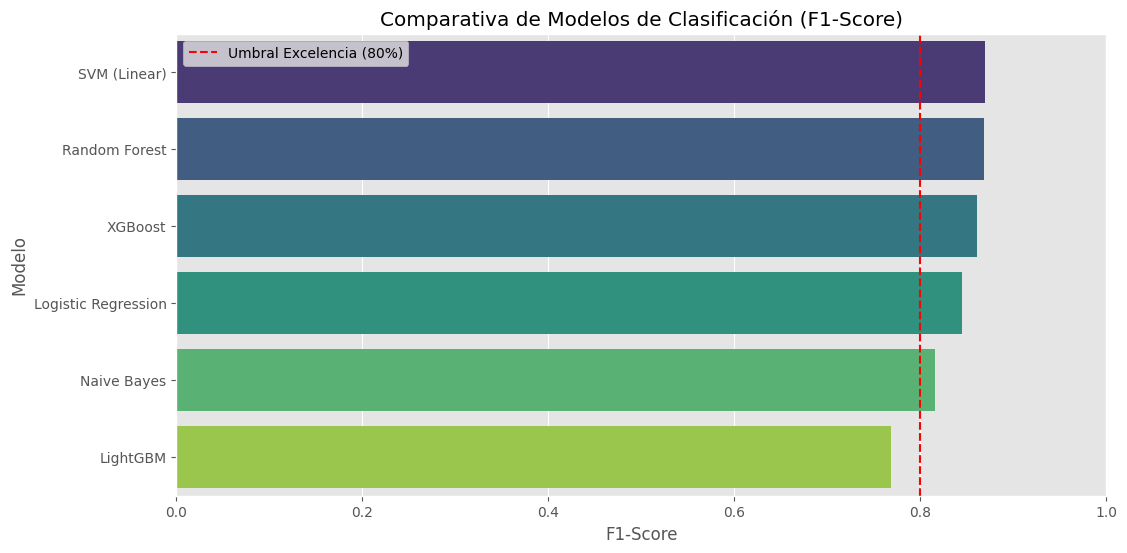


 Analizando a fondo al ganador: SVM (Linear)
                                                 precision    recall  f1-score   support

                                            ABM       0.75      0.79      0.77      1499
                                            AMI       0.60      0.86      0.70        65
                      Actividades Proyectos IMA       0.41      0.61      0.49        36
                                   Aplicaciones       0.90      0.84      0.87      3429
                                 Ciberseguridad       0.19      0.50      0.27        16
                                            DBA       0.97      0.92      0.94      5577
                                            DTE       0.46      0.66      0.54        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.05      0.20      0.08        35
                                      Folios OT       0.99      0.99      0.99       143
                                  Ingenieros TI       0.69     

In [6]:

modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    'SVM (Linear)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LinearSVC(class_weight='balanced', random_state=42))
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ]),
    'LightGBM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LGBMClassifier(n_estimators=100, n_jobs=-1, random_state=42, verbose=-1))
    ])
}

#train
resultados = []

print("\n inicio training de modelos")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # Entrenar
        pipe.fit(X_train, y_train)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted') # Weighted por el desbalance de clases
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"{nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print(df_res)

# Visualización
plt.figure(figsize=(12, 6))
sns.barplot(data=df_res, x='F1-Score', y='Modelo', palette='viridis')
plt.title('Comparativa de Modelos de Clasificación (F1-Score)')
plt.xlim(0, 1.0)
plt.axvline(0.8, color='red', linestyle='--', label='Umbral Excelencia (80%)')
plt.legend()
plt.show()

# analisis del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\n Analizando a fondo al ganador: {mejor_modelo_nombre}")
y_pred_final = mejor_pipeline.predict(X_test)

# Reporte por Clase (Recuperando nombres reales con label_map)
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))

In [20]:
# Reconstruimos un DF temporal solo con train
df_train_temp = pd.DataFrame({'texto': X_train, 'label': y_train})
conteo_train = df_train_temp['label'].value_counts()
minimo_deseado = 300 # Umbral para inflar clases chicas

dfs_extra = []
for label_code, count in conteo_train.items():
    if count < minimo_deseado:
        # Calculamos multiplicador
        multiplicador = int(round(minimo_deseado / count))
        if multiplicador > 1:
            df_subset = df_train_temp[df_train_temp['label'] == label_code]
            # Duplicamos
            dfs_extra.append(pd.concat([df_subset] * (multiplicador - 1)))
            # print(f"   -> Clase {label_map[label_code]} aumentada x{multiplicador}")

if dfs_extra:
    df_train_bal = pd.concat([df_train_temp] + dfs_extra).sample(frac=1, random_state=42)
    X_train_bal = df_train_bal['texto']
    y_train_bal = df_train_bal['label']
    print(f"Dataset Train aumentado: {len(X_train)} -> {len(X_train_bal)}")
else:
    X_train_bal, y_train_bal = X_train, y_train

# --- 3. MODELOS (CON ESTRATEGIA C: CALIBRACIÓN) ---
modelos = {
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', MultinomialNB())
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1))
    ]),
    # AQUI ESTA EL CAMBIO CLAVE PARA SVM: CalibratedClassifierCV
    'SVM (Calibrated)': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', CalibratedClassifierCV(
            LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
            method='sigmoid', cv=3)
        )
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', RandomForestClassifier(n_estimators=100, class_weight='balanced', n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words)),
        ('clf', XGBClassifier(n_estimators=100, n_jobs=-1, random_state=42, eval_metric='mlogloss'))
    ])
}

# train
resultados = []

print("\n--- INICIO TRAINING DE MODELOS ---")
for nombre, pipe in modelos.items():
    inicio = time.time()
    try:
        # datos balanceados
        pipe.fit(X_train_bal, y_train_bal)
        
        # Predecir
        y_pred = pipe.predict(X_test)
        
        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        tiempo = time.time() - inicio
        resultados.append({'Modelo': nombre, 'Accuracy': acc, 'F1-Score': f1, 'Tiempo (s)': tiempo})
        print(f"✅ {nombre}: Acc={acc:.2%} | F1={f1:.2%} | {tiempo:.1f}s")
        
    except Exception as e:
        print(f"Error en {nombre}: {e}")

# Tabla de posiciones
df_res = pd.DataFrame(resultados).sort_values('F1-Score', ascending=False)
print("\nTABLA DE RESULTADOS:")
print(df_res)

# Analisi del mejor modelo
mejor_modelo_nombre = df_res.iloc[0]['Modelo']
mejor_pipeline = modelos[mejor_modelo_nombre]

print(f"\nAnalizando al ganador: {mejor_modelo_nombre}")

# probabilidades
probs = mejor_pipeline.predict_proba(X_test)
max_probs = np.max(probs, axis=1) 
y_pred_indices = np.argmax(probs, axis=1) 
y_pred_final = mejor_pipeline.classes_[y_pred_indices]

# Reporte
print(classification_report(y_test, y_pred_final, target_names=list(label_map.values())))

#umbral de calidad
UMBRAL = 0.70 
print(f"\nSIMULACIÓN (Umbral {UMBRAL*100}%)")

y_test_array = np.array(y_test)
mask_auto = max_probs >= UMBRAL 

# Métricas Operativas
total_tickets = len(y_test)
auto_tickets = np.sum(mask_auto)
manual_tickets = total_tickets - auto_tickets

# Accuracy en los que si asignamos
if auto_tickets > 0:
    acc_operativo = accuracy_score(y_test_array[mask_auto], y_pred_final[mask_auto])
else:
    acc_operativo = 0

print(f"1. Cobertura Automática: {auto_tickets/total_tickets:.1%} ({auto_tickets} tickets)")
print(f"2. Precisión en Automático: {acc_operativo:.2%} (Esta es la fiabilidad real)")
print(f"3. Enviados a Manual: {manual_tickets/total_tickets:.1%} ({manual_tickets} tickets)")

# matriz de confusion
plt.figure(figsize=(12, 10))
nombres_clases = list(label_map.values())
cm = confusion_matrix(y_test, y_pred_final)

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
            xticklabels=nombres_clases, yticklabels=nombres_clases)
plt.title(f'Matriz de Confusión: {mejor_modelo_nombre}')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ValueError: Per-column arrays must each be 1-dimensional

In [14]:
#guardar modelo
os.makedirs('../models', exist_ok=True)
path_modelo = '../models/SVM_best.pkl'
joblib.dump(mejor_pipeline, path_modelo)
print(f"Modelo guardado exitosamente en: {path_modelo}")

Modelo guardado exitosamente en: ../models/SVM_best.pkl


In [15]:
# Instalar librería necesaria
# !pip install sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# 1. CARGAMOS UN MODELO PRE-ENTRENADO EN ESPAÑOL
print("Descargando modelo semántico (esto pasa una sola vez)...")
# 'paraphrase-multilingual-MiniLM-L12-v2' es ligero y muy bueno para español
encoder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# 2. GENERAMOS LOS EMBEDDINGS (Convertir texto a vectores de significado)
print(f"Generando embeddings para {len(df_labeled)} tickets...")
# Esto tardará unos minutos dependiendo de tu CPU/GPU
X_embeddings = encoder.encode(df_labeled['texto_limpio'].tolist(), show_progress_bar=True)

# Las etiquetas (y) siguen siendo las mismas (label_code)
y = df_labeled['label_code']

# 3. SPLIT (Igual que antes)
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

# 4. ENTRENAMOS EL CLASIFICADOR (SVM suele funcionar mejor con embeddings)
print("Entrenando SVM sobre Embeddings...")
clf_semantico = LinearSVC(class_weight='balanced', random_state=42, dual='auto')
clf_semantico.fit(X_train, y_train)

# 5. EVALUACIÓN
y_pred = clf_semantico.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n🚀 Accuracy con Modelo Semántico: {acc:.2%}")
print(classification_report(y_test, y_pred, target_names=list(label_map.values())))

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Descargando modelo semántico (esto pasa una sola vez)...


Loading weights: 100%|██████████| 199/199 [00:00<00:00, 770.54it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Generando embeddings para 102576 tickets...


Batches: 100%|██████████| 3206/3206 [06:42<00:00,  7.97it/s]


Entrenando SVM sobre Embeddings...

🚀 Accuracy con Modelo Semántico: 77.24%
                                                 precision    recall  f1-score   support

                                            ABM       0.64      0.69      0.67      1499
                                            AMI       0.28      0.77      0.41        65
                      Actividades Proyectos IMA       0.18      0.58      0.28        36
                                   Aplicaciones       0.85      0.70      0.77      3429
                                 Ciberseguridad       0.05      0.31      0.09        16
                                            DBA       0.96      0.89      0.92      5577
                                            DTE       0.16      0.51      0.24        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.03      0.26      0.05        35
                                      Folios OT       0.95      0.99      0.97       143
                                 

In [16]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Asumimos que X_embeddings, y, etc. ya existen del paso anterior.
# Si no, re-ejecuta la celda de generación de embeddings.

# 1. SPLIT (Sobre los embeddings originales)
X_train, X_test, y_train, y_test = train_test_split(X_embeddings, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensiones originales: {X_train.shape[1]} (Probablemente 768)")

# 2. DEFINIR PIPELINE CON PCA
# Paso A: Escalar (PCA es sensible a la escala, aunque los embeddings suelen venir normalizados, es buena práctica)
# Paso B: PCA (n_components=0.95 significa "Quédate con los componentes necesarios para explicar el 95% de la info")
# Paso C: SVM (LinearSVC)

pipeline_pca = Pipeline([
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=0.95, random_state=42)), 
    ('clf', LinearSVC(class_weight='balanced', random_state=42, dual='auto'))
])

print("--- Entrenando SVM sobre Embeddings Reducidos (PCA) ---")
pipeline_pca.fit(X_train, y_train)

# 3. VERIFICAR REDUCCIÓN
n_components = pipeline_pca.named_steps['pca'].n_components_
print(f"✅ PCA redujo las dimensiones de 768 a {n_components} componentes principales.")

# 4. EVALUACIÓN
y_pred_pca = pipeline_pca.predict(X_test)
acc_pca = accuracy_score(y_test, y_pred_pca)

print(f"\n🚀 Accuracy con PCA (95% Varianza): {acc_pca:.2%}")
print(classification_report(y_test, y_pred_pca, target_names=list(label_map.values())))

Dimensiones originales: 384 (Probablemente 768)
--- Entrenando SVM sobre Embeddings Reducidos (PCA) ---
✅ PCA redujo las dimensiones de 768 a 126 componentes principales.

🚀 Accuracy con PCA (95% Varianza): 71.00%
                                                 precision    recall  f1-score   support

                                            ABM       0.60      0.57      0.58      1499
                                            AMI       0.18      0.75      0.29        65
                      Actividades Proyectos IMA       0.06      0.42      0.10        36
                                   Aplicaciones       0.83      0.62      0.71      3429
                                 Ciberseguridad       0.04      0.69      0.07        16
                                            DBA       0.94      0.85      0.89      5577
                                            DTE       0.09      0.55      0.16        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.03      0.17     

In [17]:
from scipy.sparse import hstack, csr_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. GENERAR TF-IDF (El campeón actual)
print("Generando TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(df_labeled['texto_limpio'])

# 2. RECUPERAR EMBEDDINGS (El retador)
# Asumimos que 'X_embeddings' ya existe en tu memoria del paso anterior.
# Si no, tendrás que regenerarlo.
print("Procesando Embeddings...")
X_emb_sparse = csr_matrix(X_embeddings) # Convertir a dispersa para poder unir

# 3. FUSIÓN (El Monstruo)
print("Fusionando matrices (Concatenación)...")
# Esto crea una matriz gigante con 5000 columnas de palabras + 384 de significado
X_hybrid = hstack([X_tfidf, X_emb_sparse])

print(f"Dimensiones finales: {X_hybrid.shape}")

# 4. SPLIT
# Usamos las mismas etiquetas 'y' (label_code)
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hybrid, y, test_size=0.2, random_state=42, stratify=y)

# 5. ENTRENAMIENTO
print("Entrenando SVM Híbrido...")
clf_hybrid = LinearSVC(class_weight='balanced', random_state=42, dual='auto')
clf_hybrid.fit(X_train_h, y_train_h)

# 6. EVALUACIÓN
y_pred_h = clf_hybrid.predict(X_test_h)
acc_h = accuracy_score(y_test_h, y_pred_h)

print(f"\n🔥 Accuracy MODELO HÍBRIDO: {acc_h:.2%}")
print(classification_report(y_test_h, y_pred_h, target_names=list(label_map.values())))

Generando TF-IDF...
Procesando Embeddings...
Fusionando matrices (Concatenación)...
Dimensiones finales: (102576, 5384)
Entrenando SVM Híbrido...

🔥 Accuracy MODELO HÍBRIDO: 87.03%
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.83      0.80      1499
                                            AMI       0.63      0.80      0.71        65
                      Actividades Proyectos IMA       0.49      0.58      0.53        36
                                   Aplicaciones       0.91      0.86      0.89      3429
                                 Ciberseguridad       0.12      0.19      0.15        16
                                            DBA       0.97      0.93      0.95      5577
                                            DTE       0.50      0.70      0.58        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.05      0.14      0.07        35
                 

In [21]:
# --- CORRECCIÓN: ASEGURAR TIPOS COMPATIBLES ---

# 1. Reiniciamos X_train desde el DataFrame original para garantizar que sea Texto (Series)
# (Esto borra cualquier rastro de embeddings o arrays numéricos previos)
X_raw = df_labeled['texto_limpio']
y_raw = df_labeled['label_code']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw)

# 2. AHORA SÍ: FUSIÓN REAL + SINTÉTICO
# Usamos ignore_index=True para regenerar el índice y evitar duplicados
print(f"Fusionando {len(X_train)} reales con {len(df_synth)} sintéticos...")

# Aseguramos que los sintéticos sean Series también
X_synth_series = df_synth['texto_limpio']
y_synth_series = df_synth['label_code']

X_train_augmented = pd.concat([X_train, X_synth_series], ignore_index=True)
y_train_augmented = pd.concat([y_train, y_synth_series], ignore_index=True)

print(f"✅ Éxito: Dataset de Entrenamiento creció de {len(X_train)} a {len(X_train_augmented)} tickets.")

# --- 3. RE-ENTRENAMIENTO (SVM CALIBRADO) ---
print("\n--- Entrenando SVM con Datos Aumentados (Data Augmentation) ---")

pipeline_aug = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
        method='sigmoid', cv=3)
    )
])

pipeline_aug.fit(X_train_augmented, y_train_augmented)

# --- 4. EVALUACIÓN ---
y_pred_aug = pipeline_aug.predict(X_test)
acc_aug = accuracy_score(y_test, y_pred_aug)

print(f"\n🚀 Accuracy Nuevo (Data Augmentation): {acc_aug:.2%}")
print(classification_report(y_test, y_pred_aug, target_names=list(label_map.values())))

Fusionando 82060 reales con 400 sintéticos...
✅ Éxito: Dataset de Entrenamiento creció de 82060 a 82460 tickets.

--- Entrenando SVM con Datos Aumentados (Data Augmentation) ---

🚀 Accuracy Nuevo (Data Augmentation): 87.87%
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.81      0.79      1499
                                            AMI       0.81      0.74      0.77        65
                      Actividades Proyectos IMA       0.95      0.53      0.68        36
                                   Aplicaciones       0.87      0.90      0.88      3429
                                 Ciberseguridad       0.33      0.06      0.11        16
                                            DBA       0.96      0.93      0.94      5577
                                            DTE       0.70      0.60      0.65        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.00     

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import re

# --- 1. GENERACIÓN DE DATOS SINTÉTICOS (Generados por IA para ti) ---
# He creado variantes realistas para las clases donde el modelo fallaba (F1 bajo)
synthetic_data = {
    'SAP': [
        "error al ingresar a transaccion me21n", "sap gui se cierra solo inesperadamente",
        "no puedo liberar pedido en sap error de autorizacion", "bloqueo de usuario sap por intentos fallidos",
        "necesito acceso al modulo fi de sap", "error rfc en conexion con sap solution manager",
        "la pantalla de sap se queda congelada al exportar excel", "solicitud de rol para visualizar facturas sap",
        "dump en sistema sap productivo error time_out", "falla en carga masiva de datos a sap",
        "sap logon no conecta al servidor de desarrollo", "error abap en reporte z_ventas",
        "creacion de acreedor en sap da error de datos maestros", "problema con impresora local desde sap",
        "transaccion lenta en sap modulo mm", "error de logueo sap clave incorrecta",
        "solicito resetear password de sap mandante 300", "error de comunicacion idoc en sap",
        "mensaje de error al contabilizar en sap", "actualizacion de parche sap gui necesaria"
    ],
    'Ciberseguridad': [
        "correo sospechoso posible phishing de banco", "alerta de antivirus en mi equipo detecto malware",
        "bloqueo de pagina web por firewall corporativo", "solicitud de excepcion en proxy para sitio gobierno",
        "reporte de vulnerabilidad en servidor web", "intento de acceso no autorizado a mi cuenta",
        "computador lento y con ventanas emergentes virus", "necesito habilitar puerto usb bloqueado por seguridad",
        "analisis de seguridad para nuevo software", "correo con adjunto malicioso recibido",
        "alerta de seguridad de microsoft defender", "bloqueo de cuenta por politicas de seguridad",
        "sospecha de ransomware en carpeta compartida", "solicitud de acceso a vpn con doble factor",
        "cambio de politicas de contraseñas seguridad", "fuga de informacion detectada en log",
        "scan de vulnerabilidades solicita parche urgente", "sitio web marcado como inseguro por navegador",
        "notificacion de inicio de sesion desde pais extraño", "revision de permisos de carpeta sensible"
    ],
    'Desarrollo de Sistemas y Proyectos Tecnológicos': [
        "bug critico en despliegue de aplicacion web", "error 500 en api rest de facturacion",
        "fallo en pipeline de ci/cd jenkins", "base de datos de desarrollo no responde",
        "error de compilacion en proyecto java", "solicitud de merge request en gitlab",
        "problema con variable de entorno en produccion", "servicio docker se reinicia constantemente",
        "latencia alta en endpoint de consulta de clientes", "error de javascript en frontend react",
        "falla en integracion con pasarela de pagos", "actualizacion de libreria rompe compatibilidad",
        "hotfix urgente para error en calculo de iva", "script de migracion de datos falla",
        "error de conexion a base de datos mongo desde node", "revision de codigo para pase a produccion",
        "ambiente deqa no accesible", "logs de aplicacion muestran error de nullpointer",
        "timeout en servicio web soap", "rollback de version por fallas masivas"
    ],
    'PowerOn': [
        "sistema poweron no actualiza estado de clientes", "error de conexion con servidor poweron",
        "no puedo visualizar mapa en poweron", "falla en modulo de cortes de poweron",
        "usuario bloqueado en aplicativo poweron", "diferencia de datos entre poweron y sap",
        "lentitud extrema en consultas de poweron", "reporte de interrupciones poweron vacio",
        "error al asignar brigada en poweron", "poweron móvil no sincroniza datos",
        "alerta de falla en integracion scada poweron", "pantalla negra al abrir poweron",
        "error de licencia en terminal poweron", "solicitud de creacion de usuario poweron",
        "datos de empalme incorrectos en poweron", "falla al cerrar orden en poweron",
        "sistema poweron fuera de linea", "error de gis dentro de interfaz poweron",
        "actualizacion de poweron pendiente", "problema con despacho de ordenes poweron"
    ]
}

# Convertimos el diccionario a DataFrame
rows = []
for area, titulos in synthetic_data.items():
    for t in titulos:
        # Repetimos cada ejemplo sintético 5 veces para darle peso (Volumen)
        # Esto simula haber generado 100 tickets en vez de 20
        for _ in range(5): 
            rows.append({'titulo': t, 'area': area, 'origen': 'sintetico'})

df_synth = pd.DataFrame(rows)

# Limpieza de texto para los sintéticos
def limpiar_texto(texto):
    if not isinstance(texto, str): return ""
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ ]', '', texto)
    return texto.strip()

df_synth['texto_limpio'] = df_synth['titulo'].apply(limpiar_texto)

# Label Encoding (Usamos el mismo encoder que ya tenías entrenado 'le')
# ¡OJO! Asegúrate de que 'le' exista. Si no, recréalo con df_train.
df_synth['label_code'] = le.transform(df_synth['area'])

print(f"🤖 Se han generado {len(df_synth)} tickets sintéticos de alta calidad.")

# --- 2. FUSIÓN: REAL + SINTÉTICO ---
# Tomamos tus datos de entrenamiento originales (X_train, y_train)
# Y le pegamos los sintéticos
X_train_augmented = pd.concat([X_train, df_synth['texto_limpio']])
y_train_augmented = pd.concat([y_train, df_synth['label_code']])

print(f"Dataset de Entrenamiento: {len(X_train)} -> Aumentado: {len(X_train_augmented)}")

# --- 3. RE-ENTRENAMIENTO DEL MODELO CLÁSICO (SVM) ---
print("\n--- Entrenando SVM con Datos Aumentados por IA ---")

# Usamos el Pipeline Ganador (SVM Calibrado)
pipeline_aug = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, stop_words=stop_words, ngram_range=(1, 2))),
    ('clf', CalibratedClassifierCV(
        LinearSVC(class_weight='balanced', random_state=42, dual='auto'),
        method='sigmoid', cv=3)
    )
])

pipeline_aug.fit(X_train_augmented, y_train_augmented)

# --- 4. EVALUACIÓN ---
# Evaluamos contra X_test ORIGINAL (Nunca evaluar con datos sintéticos)
y_pred_aug = pipeline_aug.predict(X_test)
acc_aug = accuracy_score(y_test, y_pred_aug)

print(f"\n🚀 Accuracy Nuevo (Data Augmentation): {acc_aug:.2%}")
print(classification_report(y_test, y_pred_aug, target_names=list(label_map.values())))

🤖 Se han generado 400 tickets sintéticos de alta calidad.
Dataset de Entrenamiento: 82060 -> Aumentado: 82460

--- Entrenando SVM con Datos Aumentados por IA ---

🚀 Accuracy Nuevo (Data Augmentation): 87.87%
                                                 precision    recall  f1-score   support

                                            ABM       0.78      0.81      0.79      1499
                                            AMI       0.81      0.74      0.77        65
                      Actividades Proyectos IMA       0.95      0.53      0.68        36
                                   Aplicaciones       0.87      0.90      0.88      3429
                                 Ciberseguridad       0.33      0.06      0.11        16
                                            DBA       0.96      0.93      0.94      5577
                                            DTE       0.70      0.60      0.65        53
Desarrollo de Sistemas y Proyectos Tecnológicos       0.00      0.00      0.00 

/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ubuntu/projects/historical-analysis-management-tickets/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Us

In [ ]:
df_all.to_csv(f"{folder_p}/df_all.csv")

In [34]:
folder_p = "/home/ubuntu/projects/historical-analysis-management-tickets/data/processed"
df_ciber = df_all[df_all["area"] == "Ciberseguridad"][["categoria","titulo"]]
df_ciber.to_csv(f"{folder_p}/contexto_ciber.csv")

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report

# 1. CARGAR Y LIMPIAR TUS DATOS REALES DE CIBERSEGURIDAD
# Asumimos que subiste el archivo 'contexto_ciber.csv'
df_ciber_real = pd.read_csv('/home/ubuntu/projects/historical-analysis-management-tickets/data/processed/contexto_ciber.csv')

def limpiar_titulo_ciber(texto):
    if not isinstance(texto, str): return ""
    # Quitar ID al final (NNNN) y prefijos de correo
    texto = re.sub(r'\(\d+\)$', '', texto)
    texto = re.sub(r'^(RV|rv|Rv|RE|re|Re):\s*', '', texto)
    texto = re.sub(r'\[GLPI #\d+\]', '', texto)
    # Limpieza estándar
    texto = texto.lower()
    texto = re.sub(r'[^a-záéíóúñ ]', '', texto)
    return texto.strip()

df_ciber_real['texto_limpio'] = df_ciber_real['titulo'].apply(limpiar_titulo_ciber)
df_ciber_real['area'] = 'Ciberseguridad' # Aseguramos la etiqueta correcta
print(f"✅ Cargados {len(df_ciber_real)} tickets reales de Ciberseguridad.")

# 2. PREPARAR TU DATASET PRINCIPAL (df_all)
# (Asumimos que ya tienes X_train, y_train de tu df_all original)
# Si no, asegúrate de tener X_train (textos limpios) y y_train (etiquetas) listos aquí.

# 3. FUSIÓN Y AUGMENTATION (El Secreto del Éxito)
# En lugar de inventar datos, tomamos tus reales y los multiplicamos x10
# para que el modelo los vea tantas veces como ve a 'DBA' o 'Soporte'.

MULTIPLICADOR = 10 
X_ciber_aug = pd.concat([df_ciber_real['texto_limpio']] * MULTIPLICADOR, ignore_index=True)
y_ciber_aug = pd.concat([df_ciber_real['area']] * MULTIPLICADOR, ignore_index=True)

# Si usaste LabelEncoder antes, recuerda transformar y_ciber_aug
# y_ciber_aug = le.transform(y_ciber_aug) 

print(f"Injectando {len(X_ciber_aug)} ejemplos de Ciberseguridad al entrenamiento...")

# Unimos todo
y_train_text = le.inverse_transform(y_train)
y_train_text = pd.Series(y_train_text)

MULTIPLICADOR = 10

y_ciber_aug_text = pd.Series(['Ciberseguridad'] * (len(df_ciber_real) * MULTIPLICADOR))

y_train_final_text = pd.concat([y_train_text, y_ciber_aug_text], ignore_index=True)

X_ciber_aug = pd.concat([df_ciber_real['texto_limpio']] * MULTIPLICADOR, ignore_index=True)
X_train_final = pd.concat([X_train, X_ciber_aug], ignore_index=True)

print(f"✅ Fusión Correcta: X={len(X_train_final)}, y={len(y_train_final_text)}")

le_final = LabelEncoder()
y_train_final_encoded = le_final.fit_transform(y_train_final_text)

# 4. ENTRENAMIENTO FINAL (SVM Calibrado)
pipeline_final = Pipeline([
    # N-gramas (1,2) ayudan a capturar "permiso python" como una sola idea
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))), 
    ('clf', CalibratedClassifierCV(LinearSVC(class_weight='balanced'), cv=3))
])

print("Entrenando modelo final...")
pipeline_final.fit(X_train_final, y_train_final)

# 5. EVALUACIÓN
print("Evaluando...")
y_pred_encoded = pipeline_final.predict(X_test)
# Invertimos la predicción a texto para leer el reporte
y_pred_text = le_final.inverse_transform(y_pred_encoded)
# Invertimos también el y_test original a texto
y_test_text = le.inverse_transform(y_test)

print(classification_report(y_test_text, y_pred_text))

✅ Cargados 78 tickets reales de Ciberseguridad.
Injectando 780 ejemplos de Ciberseguridad al entrenamiento...
Entrenando modelo final...


ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.